
Bézier curves are polynomials of t, they can be implemented using simple polynomials. When a new control point is introduced the curve degree increases making the computational cost rise exponentially. The following code will implement a general method to test n-control points and n-dimension curves. Take a look at the following formulas to see what we need to generalize.

$$linear -> (1-t)+t $$
$$cuadratic -> (1-t)² + 2 * (1-t)* t + t² $$
$$cubic -> (1-t)³ + 3 * (1-t)² * t + 3 * (1-t) * t² + t³$$



The following formula generalize the bezier creation with a binomial and a polynomial term, notice this representation works for each of the control point coordinate components. Taking a binomial and then computing the corresponding polynomial will give us a general reusable function.

$$ bezier(n,k,t) =  \sum_{n=1}^{n} \binom{n}{k} * (1-t)^{n-k} * t^{k}$$

In the following cells, we'll see how these simple functions that create the curve can be automatically accelerated by CUDA. This code is especially designed to run on Nvidia hardware, that means that we'll observe better times just on that hardware. Notice how the sum implementation can be easily accelerated with numba.prange instead of regular Python range loop.

In [ ]:
from numba import jit
from numba import cuda

import numba
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
@numba.njit

def fact (number):

    fact = 1

    for i in range(1,number+1):
        
        fact = fact * i

    return fact

In [ ]:
@numba.njit

def binomial(x, y):
        
        return fact(x) // fact(y) // fact(x - y)

In [ ]:
@numba.njit

def polynomial(n, i, t):

    return pow((1 - t), (n - i)) * pow (t, i)

In [ ]:
@numba.njit(parallel=True)

def bezier_func(n, t, w):

    sum = 0

    for i in numba.prange(0, n+1, 1):
      
        sum += binomial(n, i) * polynomial (n, i, t) * w[i] 

    return sum

We have seen the required functions to obtain a point on a given bezier curve, but we need some control points to draw the line. We use a random generation approach to hande the control points, we define the generation function based on the number of points we need and the dimension of the points, such as 2D or 3D.

In [ ]:
# generate n -dimensional control points:

def r_n_dim_control(dim, elems):

    import random
  
    N, R = 5, 10

    res = [random.sample(range((R + 1) * (R + 1)), dim) for _ in range(elems)]

    return res

In [ ]:
curves_control = [r_n_dim_control(2, 20) for _ in range(3)]

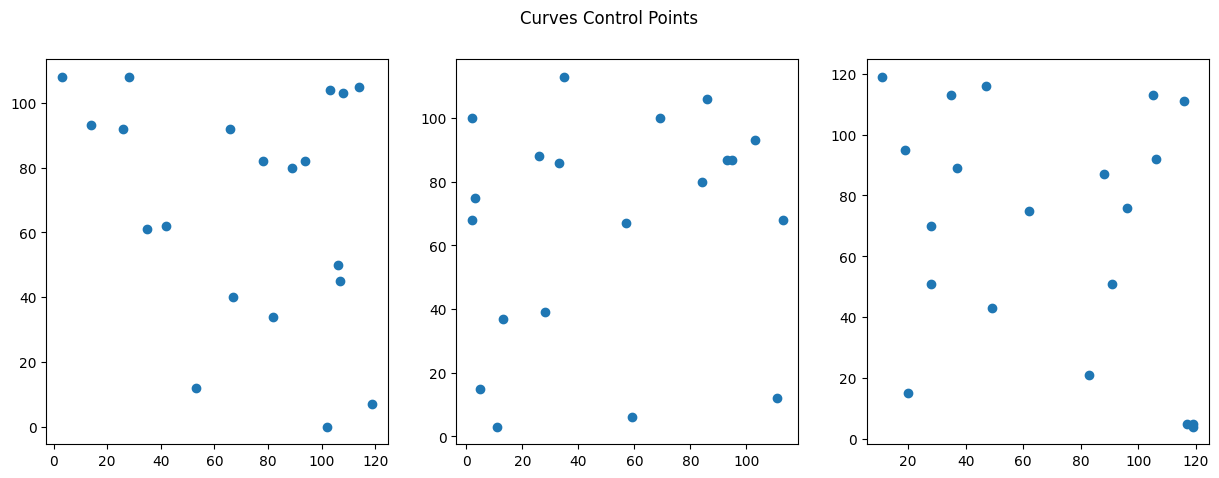

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle('Curves Control Points')

for idx, control in enumerate(curves_control):

    axs[idx].scatter(*zip(*control))

Ok, now we need to define the get point function to calculate the point in space based on the control point data and the bezier functions already implemented. Since the implementation can be reused with multiple dimension, the following function unzips the point data for each of its dimensions  (we have different arrays with the x, y, z corresponding values) and then computes the asociated bezier.

In [ ]:
# pll

def get_point(points, t):

    grade = len(points)-1

    i_comps = list(zip(*points))

    t_point = [ bezier_func(grade, t, i_comps[x]) for x in range(len(i_comps)) ]

    return t_point

The following lines contain the splitted execution to handle a 3D point calculation based on some control_points:

In [ ]:
%timeit b2 = [ get_point(curves_control[0], t) for t in np.linspace(0.0, 1.0, num=1000) ]

The slowest run took 4.07 times longer than the fastest. This could mean that an intermediate result is being cached.
35.3 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit b2 = [ get_point(curves_control[1], t) for t in np.linspace(0.0, 1.0, num=1000) ]

The slowest run took 4.02 times longer than the fastest. This could mean that an intermediate result is being cached.
70.8 ms ± 37.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit b2 = [ get_point(curves_control[2], t) for t in np.linspace(0.0, 1.0, num=1000) ]

15.5 ms ± 8.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
curves_control = [r_n_dim_control(2, 20) for _ in range(3)]

In [ ]:
res = [ [ get_point(curves_control[i], t) for t in np.linspace(0.0, 1.0, num=1000) ] for i in range(3) ]

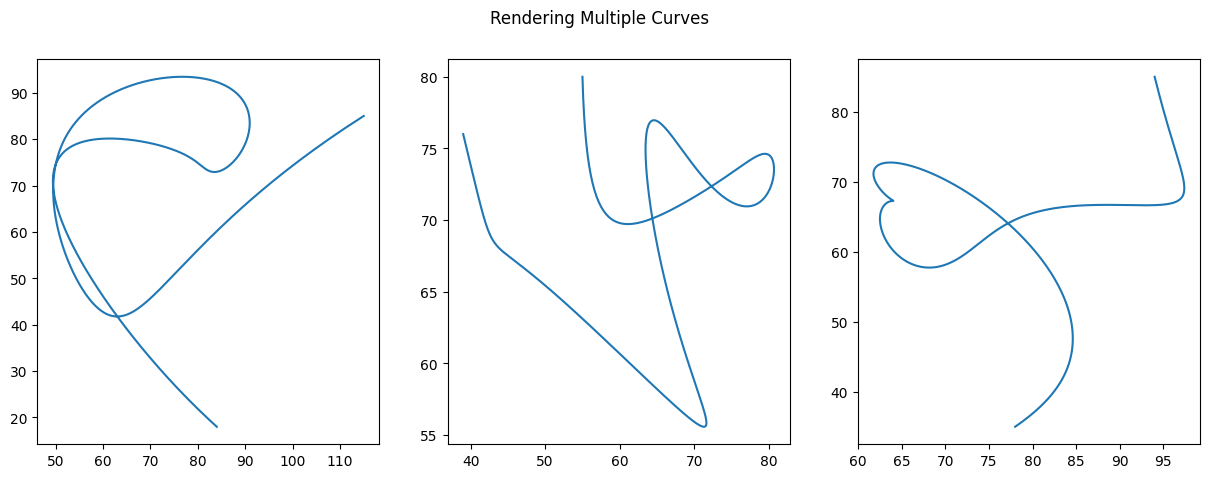

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle('Rendering Multiple Curves')

for idx, bezier in enumerate(res):

    axs[idx].plot(*zip(*bezier))

The following bash instructions allow us to compile C++ CUDA code directly from this notebook and then execute the program. The notebook has been executed from Google Colab, below you can see the hardware specifications that we're running on. 

Now, we reimplemented the previous functions to use CUDA from C++ at the lowest level, then we compare the performance. Notice the only thing suitable for parallel optimization is the sum of the formula. We use the device the best way possible to use each cell in the grid execute an operation. In order to write c++ code from a ipynb notebook we use the magic function %%writefile to save cell code into a file and then compile it with the nvcc nvidia's compiler.

In [ ]:
!ls /usr/local/

bin    cuda	cuda-11.8  games	       include	lib64	   man	 share
colab  cuda-11	etc	   _gcs_config_ops.so  lib	licensing  sbin  src


In [ ]:
!which nvcc

/usr/local/cuda/bin/nvcc


In [ ]:
!nvidia-smi

Sun Jun 11 09:33:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The following lines of code contain the equivalent c++ implementation to the previous functions written in Python. Just by executing the c++ code we obtain a speed-up, but here we also focus on the required syntax to execute on the nvidia hardware and accelerate with the device. The %%writefile bezier.cu instruction saves the cell code into a file called bezier.cu that can be later compiled.

In [ ]:
#The bezier.cu programs needs to be executed from python, we need to handle dynamic memory to pass arrays as arguments to the program.

In [ ]:
%%writefile bezier.cu

#include<stdio.h>
#include <cmath>

#include <iostream>
using namespace std;

// Returns value of Binomial Coefficient C(n, k)

int binomial(int n, int k)
{
    // Base Cases
    if (k > n){ return 0; }

    if (k == 0 || k == n) { return 1; }

    // Recur
    return binomial(n - 1, k - 1) + binomial(n - 1, k);
}

float polynomial(int n, int i, float t)
{
    return pow((1 - t), (n - i)) * pow (t, i);
}

float bezier(int n, float t, float * w)
{
    float sum = 0;

    for (int i = 0; i < (n + 1); i ++ )
    {
        sum += ( binomial(n, i) * polynomial (n, i, t) * w[i] );
    }

    return sum;
}

int main(int argc,char *argv[])
{
    float * f_weights = new float[argc];

    for (int loop = 0; loop < argc; loop++) {
      
        f_weights[loop] = atof(argv[loop]);
    }

    int n = argc - 1;
    float t = 0.5;
    float* w = f_weights;

    float b = bezier(n, t, f_weights);

    cout << b << endl;

    return 0;
}

Writing bezier.cu


In [ ]:
# we then compile and execute the nvidia accelerated code with the following commads.

In [ ]:
!nvcc -arch=sm_37 -gencode=arch=compute_37,code=sm_37 bezier.cu -o bezier

nvcc warning : The 'compute_35', 'compute_37', 'sm_35', and 'sm_37' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
bezier.cu(49): warning #177-D: variable "w" was declared but never referenced



In [ ]:
curves_control = [r_n_dim_control(3, 25) for _ in range(3)]

In [ ]:
# need to transform float array to single string, this way we can evaluate this string and pass it as a paramter to the bezier program.

points_c = list(zip(*curves_control[0]))

def float_arr_to_str(arr):

  return " ".join([str(i) for i in arr])

In [ ]:
# convert

bezier_x = " ".join([str(i) for i in points_c[0]])

bezier_y = " ".join([str(i) for i in points_c[1]])

bezier_z = " ".join([str(i) for i in points_c[2]])

In [ ]:
%time !./bezier {bezier_x}

53.4565
CPU times: user 7.04 ms, sys: 58 µs, total: 7.1 ms
Wall time: 305 ms


In [ ]:
%time !./bezier {bezier_y}

64.9291
CPU times: user 4.26 ms, sys: 2.06 ms, total: 6.32 ms
Wall time: 306 ms


In [ ]:
%time !./bezier {bezier_z}

74.2294
CPU times: user 6.18 ms, sys: 1.06 ms, total: 7.24 ms
Wall time: 305 ms


Along the notebook cells we have seen how bezier curves can run in parallel. Our purpose is to run high grade curves to analyze the behaviour, however, we know, from graphics theory, that cubic bezier are the most used to construct splines.

We design the bezier program to take the curve weights as parameters into a float array. Since CUDA kernels won't handle STD operations, we need to manage the dynamic memory ourselves. The following code reproduces the early behaviour for the sequential approach.

In [ ]:
%%writefile bezier_CUDA.cu

#include<stdio.h>
#include <cmath>

#include <iostream>
using namespace std;

__device__ int binomial(int n, int k)
{
    // Base Cases
    if (k > n){ return 0; }

    if (k == 0 || k == n) { return 1; }

    // Recur
    return binomial(n - 1, k - 1) + binomial(n - 1, k);
}

__device__ float polynomial(int n, int i, float t)
{
    return pow((1 - t), (n - i)) * pow (t, i);
}

__global__ void bezier(int n, float t, float * w, float * b)
{
    int i = threadIdx.x;

    atomicAdd(b, binomial(n, i) * polynomial (n, i, t) * w[i]);

    // printf("%lf\n", *b);
}

Writing bezier_CUDA.cu


In [ ]:
%%writefile -a bezier_CUDA.cu

int main(int argc,char *argv[])
{
    float * f_weights = new float[argc];

    // transform input to dynamic float array
    for (int loop = 0; loop < argc; loop++) {
        f_weights[loop] = atof(argv[loop]);
    }

    int n = argc - 1;
    float t = 0.5;
    float *w;
    float *b;

    int deviceId; cudaGetDevice(&deviceId);

    cudaMalloc((void**)&w, argc*sizeof(float));
    cudaMallocManaged(&b, sizeof(float));

    cudaMemcpy(w, f_weights, argc*sizeof(float), cudaMemcpyHostToDevice);
    cudaMemPrefetchAsync(b, sizeof(float), deviceId);

    cudaError_t addVectorsErr; cudaError_t asyncErr;

    // kernel CUDA call
    bezier<<<1, n>>>(n, t, w, b);

    addVectorsErr = cudaGetLastError(); asyncErr = cudaDeviceSynchronize();
    
    if(addVectorsErr != cudaSuccess) printf("Error: %s\n", cudaGetErrorString(addVectorsErr));
    if(asyncErr != cudaSuccess) printf("Error: %s\n", cudaGetErrorString(asyncErr));

    // Data back to host
    cudaMemPrefetchAsync(b, sizeof(float), cudaCpuDeviceId);

    cout << b[0] << endl;

    cudaFree(b);

    return 0;
}

Appending to bezier_CUDA.cu


In [ ]:
!nvcc -arch=sm_37 -gencode=arch=compute_37,code=sm_37 bezier_CUDA.cu -o bezier_CUDA

nvcc warning : The 'compute_35', 'compute_37', 'sm_35', and 'sm_37' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
ptxas warning : Stack size for entry function '_Z6bezierifPfS_' cannot be statically determined


In [ ]:
%time !./bezier_CUDA {bezier_x}

53.4565
CPU times: user 30.2 ms, sys: 10.4 ms, total: 40.6 ms
Wall time: 5.72 s


In [ ]:
%time !./bezier_CUDA {bezier_y}

64.9291
CPU times: user 26.4 ms, sys: 9.93 ms, total: 36.3 ms
Wall time: 5.32 s


In [ ]:
%time !./bezier_CUDA {bezier_z}

74.2294
CPU times: user 25.9 ms, sys: 7.81 ms, total: 33.7 ms
Wall time: 5.32 s


Our last example is going to include the C++ and Python code integration. Cuda C++ Kernels can be executed from Python's Pycuda SourceModule. The following code uses the previously defined bezier cuda kernel, and it executes it many times at different t values to render some 3D curves.

In [ ]:
%%capture 

! pip install pycuda

In [ ]:
import pycuda.autoinit
import pycuda.driver as drv

from pycuda.compiler import SourceModule

import cupy as cp

In [ ]:
def get_point_CUDA(points, t):

  mod = SourceModule("""

  __device__ int binomial(int n, int k)
  {
      if (k > n){ return 0; }

      if (k == 0 || k == n) { return 1; }

      return binomial(n - 1, k - 1) + binomial(n - 1, k);
  }

  __device__ float polynomial(int n, int i, float t)
  {
      return pow((1 - t), (n - i)) * pow (t, i);
  }

  __global__ void bezier(int n, float t, float * w, float * b)
  {
      int i = threadIdx.x;

      atomicAdd(b, binomial(n, i) * polynomial (n, i, t) * w[i]);
  }

  """)

  bezier = mod.get_function("bezier")

  grade = len(points)-1

  i_comps = list(zip(*points))

  t_point = []

  for w in i_comps:

    b = 0.0

    # https://forums.developer.nvidia.com/t/passing-scalar-to-functions-cupy-pycuda-scalar-multiplication-of-a-vector/179453

    c_b = np.array([b]).astype(np.float32)
    c_w = np.array( w ).astype(np.float32)

    # CUDA call:

    bezier( 
        
        np.int32(grade), np.float32(t), drv.In(c_w), drv.Out(c_b), 

        block=(grade,1,1), grid=(1,1)
    )

    t_point.append(c_b[0])

  return t_point


In [ ]:
get_point_CUDA(curves_control[0], 0.5) 

<ipython-input-37-4485e02d5224>:3: UserWarning: The CUDA compiler succeeded, but said the following:
ptxas warning : Stack size for entry function 'bezier' cannot be statically determined

  mod = SourceModule("""


[56.05829, 65.9611, 76.048]

In [ ]:
# %time b2_CUDA_0 = [ get_point_CUDA(curves_control[0], t) for t in np.linspace(0.0, 1.0, num=100) ]

In [ ]:
# %time b2_CUDA_1 = [ get_point_CUDA(curves_control[1], t) for t in np.linspace(0.0, 1.0, num=100) ]

In [ ]:
# %time b2_CUDA_2 = [ get_point_CUDA(curves_control[2], t) for t in np.linspace(0.0, 1.0, num=100) ]

In [ ]:
# RENDER 3D CURVES AGAIN:

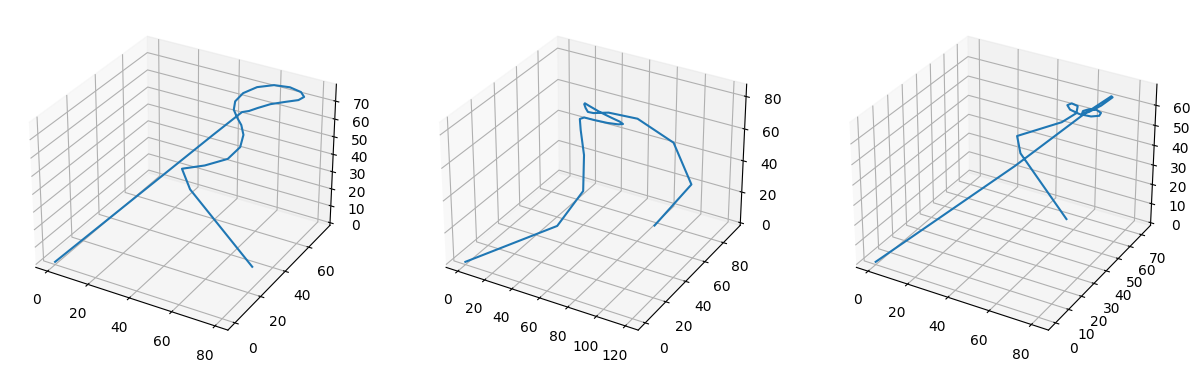

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(projection='3d'))

beziers = [ [ get_point_CUDA(curves_control[i], t) for t in np.linspace(0.0, 1.0, num=25) ] for i in range(3) ]

for idx, bezier in enumerate(beziers):

    xs, ys, zs = list(zip(*bezier))

    axs[idx].plot(xs, ys, zs)

plt.show()